In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import csv

**Logistic Regression**

This will deal with the problem of a binary classifier mapping inputs $x^{(i)}$ to one of two targets, $y^{(i)} = \{1,-1\}$ using the hypothesis $y^{(i)} = g(\theta^Tx^{(i)})$, where $g(z) = (1+e^{-z})^{-1}$. Note that, in this case, since $1-g(z) = g(-z)$ we can write the conditional probability as $P(y^{(i)}|x^{(i)},\theta) = g(y^{(i)}\theta^Tx^{(i)})$. This leads to a cost function (negative log-likelihood) of 

$J(\theta) = -\frac{1}{N}\sum log(g(y^{(i)}\theta^Tx^{(i)}))$, 

which we want to minimize using Newton's method.

Due to the property $g'(z) = g(z)(1-g(z))$, we have the gradient 

$\nabla_jJ = \frac{\partial J}{\partial \theta_j} = -\frac{1}{N}\sum g(-y^{(i)}\theta^Tx^{(i)})y^{(i)}x^{(i)}_j$,

and the Hessian

$H_{j,k} =  \frac{\partial^2 J}{\partial \theta_j\partial \theta_k} = \frac{1}{N}\sum g(-y^{(i)}\theta^Tx^{(i)})g(y^{(i)}\theta^Tx^{(i)})x^{(i)}_jx^{(i)}_k$,

where we note that $y^{(i)}$ has dropped out since $(y^{(i)})^2 = 1$.

To minimize this cost function, we will use Newton's algorithm. This means using the update rule $\theta := \theta-H^{-1}\nabla_jJ$ to converge to the point where the derivative is zero. Since this function is convex, we know this minimum is the global one.

First, we define the function which will perform Newton's method to update the weights:

In [2]:
def logisticRegression(features,targets,weights):
    """
    Inputs:
    features: NxM NumPy array of data features
    targets: NX1 NumPy array of targets
    weights: MX1 NumPy array of weights

    Output:
    Updates the weights for logistic regression 
    binary classification using Newton's algorithm,
    and returns the new value of the cost function J
    """
    margins = targets*np.dot(features,weights)
    N = np.shape(features)[0]
    sig = 1.0/(1+np.exp(margins))
    gradJ = -np.dot(features.T,targets*sig)/N
    hessJ = np.dot(features.T,np.dot(np.diagflat(sig*(1-sig)),features))/N
    weights -= np.dot(inv(hessJ),gradJ)
    newMargins = targets*np.dot(features,weights)
    newJ = np.sum(np.log(1+np.exp(-newMargins)))/N
    return newJ

Now, we'll read in the provided features (two variables per feature in this case, plus an additional variable equal to 1 added on for the intercept term), targets (list of +1, -1), and initialize the weights to zero.

In [3]:
features = np.array(list(csv.reader(open('logistic_x.txt','r'),delimiter=' ',quoting=csv.QUOTE_NONNUMERIC))) # Nx2 array
(nFeatures,nWeights) = np.shape(features) 
nWeights += 1
intercepts = np.ones((nFeatures,1)) # Nx1 array of ones
features = np.concatenate((intercepts,features),axis=1) # Nx3 array, first column is ones

In [4]:
targets = np.array(list(csv.reader(open('logistic_y.txt','r'),delimiter=' ',quoting=csv.QUOTE_NONNUMERIC)))

In [5]:
weights = np.zeros((nWeights,1))

Now, use our logistic regression function to iterate Newton's method. I'm going to be lazy here and just run for a ton of iterations rather than check for convergence, because it's fast.

In [6]:
for iterNum in range(1000):
    JVal = logisticRegression(features,targets,weights)

In [7]:
weights,JVal

(array([[-2.6205116 ],
        [ 0.76037154],
        [ 1.17194674]]), 0.329147431295712)

Okay, let's check that our answer has converged

In [8]:
JVal = logisticRegression(features,targets,weights)
weights,JVal

(array([[-2.6205116 ],
        [ 0.76037154],
        [ 1.17194674]]), 0.329147431295712)

Sweet. Now, let's use these weights to compute the hypothesis for each feature, and bin the results to be +1 or -1 (remember the hypothesis is technically continuous). Then, we'll plot the data, with a different symbol for each type. We should see a clear decision boundary between the two types if logistic regression was reasonable for this problem.

In [9]:
values = np.ndarray.flatten(1.0/(1+np.exp(-np.dot(features,weights))))

We'll plot the first feature variable on the x-axis, second on the y-axis, and split them into two sets based on the output values.

In [10]:
x1 = features[values>=0.5,1]
x2 = features[values<0.5,1]
y1 = features[values>=0.5,2]
y2 = features[values<0.5,2]
xBoundary = features[:,1]
yBoundary = -(weights[1]*xBoundary+weights[0])/weights[2]

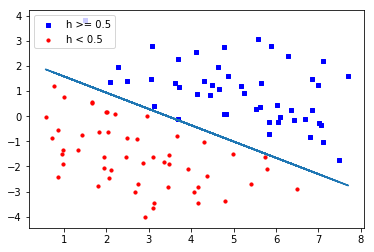

In [11]:
plt.scatter(x1,y1,s=10,c='b',marker="s",label='h >= 0.5')
plt.scatter(x2,y2,s=10,c='r',marker="o",label='h < 0.5')
plt.plot(xBoundary,yBoundary)
plt.legend(loc='upper left');
plt.show()